In [1]:
%load_ext autoreload 
%autoreload 2 

In [2]:
# import packages
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import torch
from captum.attr import visualization as viz
import numpy as np
from torchvision.models import resnet50
import torchvision.transforms as transforms

import image_manipulation as im
import feature_map as fm

In [3]:
# check if a GPU is available 
if torch.cuda.is_available():
    print('Cuda is available and used.')
    device = 'cuda'
else:
    device = 'cpu'
    print('please use a GPU for a faster performance.')

Cuda is available and used.


In [4]:
# 50 images from ImageNet data set 
import shap
import json
X, y = shap.datasets.imagenet50()

# getting ImageNet 1000 class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
with open(shap.datasets.cache(url)) as file:
    class_names = [v[1] for v in json.load(file).values()]
print("Number of ImageNet classes:", len(class_names))

Number of ImageNet classes: 1000


In [5]:
network = resnet50(pretrained=True)
network.to(device).eval()
print('The pre-trained ResNet model is loaded successfully')

The pre-trained ResNet model is loaded successfully


In [6]:
# update plt parameters
rc = {"axes.spines.left" : True,
      "axes.spines.right" : True,
      "axes.spines.bottom" : True,
      "axes.spines.top" : True,
      "xtick.bottom" : False,
      "xtick.labelbottom" : False,
      "ytick.labelleft" : False,
      "ytick.left" : False}
plt.rcParams.update(rc)

In [7]:
# data transformation 
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
data_transform = transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ])

# softmax
softy = torch.nn.Softmax(dim=-1)

The selected image is from basketball class with 99.81951141357422%


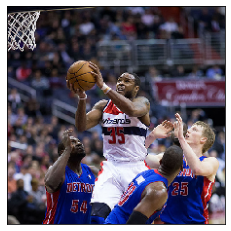

In [8]:
# 1 = American_egret, 2 = speedboat, 3 = puck, 7 = mask, 11 = bittern, 21 = Burger, 30 = sorrel
# 40 = bottle, 44 = Basketball, 45 = bolete
image_index = 44
image = X[image_index]

# classify image
image_for_classification = image / 255
image_to_explain = data_transform(image_for_classification)
network_output = network(image_to_explain.to(device).reshape(-1,3,224,224))

# softmax to get correct probability
network_output = softy(network_output)

# get the ouputs sorted descending
topk_prob, topk_label = torch.topk(network_output, 1000)

# print class and probability
baseline_target = topk_label[0][0]
class_prob = topk_prob[0][0]
print('The selected image is from {} class with {}%'.format(class_names[baseline_target], class_prob * 100))

plt.imshow(image_for_classification)
plt.show()

In [9]:
# hyperparameters
patch_size = 4
iterations = 100

# batch size
batch_size = 50

# create patches of image
patches = im.make_patches(image_for_classification, patch_size)

# create copy of patches to work with
patches_copy = np.copy(patches)

In [10]:
# check percentage for correct class in shuffled image with perturbation option

# empty cache
torch.cuda.empty_cache()

"""
removed_patch_option:   0 = shuffle and test without removing any patch
                        1 = black
                        2 = mean color of original image
                        3 = random other patch 
                        4 = most cosine distant patch
"""
option = [0,1,2,3,4]

mean_list, std_list = fm.calc_shuffle_probabilities(network, device, iterations, patches_copy, batch_size, baseline_target, option)



  0%|          | 0/5 [00:00<?, ?it/s]

Option: Shuffle and Test without perturbing any patch


  0%|          | 0/1 [00:00<?, ?it/s]

Baseline value without removing any patch:
Mean probability:  0.7488644351065159
Standard deviation:  0.1978089563940538
Option: Insert black patch


  0%|          | 0/16 [00:00<?, ?it/s]

Option: Insert mean color patch


  0%|          | 0/16 [00:00<?, ?it/s]

Option: Insert random other patch


  0%|          | 0/16 [00:00<?, ?it/s]

Option: Insert most cosine distant patch


  0%|          | 0/16 [00:00<?, ?it/s]

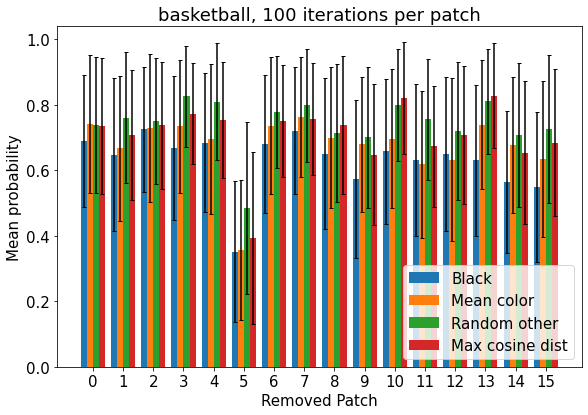

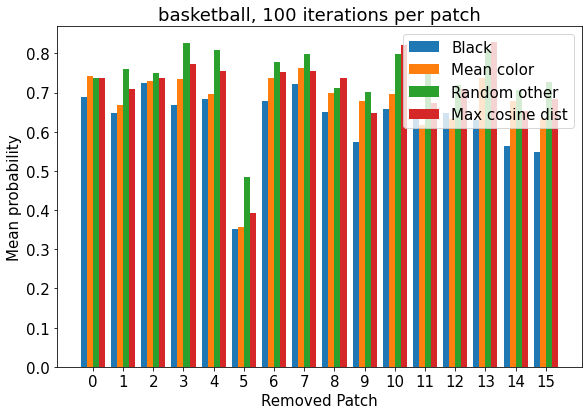

In [11]:
# make graph out of mean list

rc = {"axes.spines.left" : True,
      "axes.spines.right" : True,
      "axes.spines.bottom" : True,
      "axes.spines.top" : True,
      "xtick.bottom" : True,
      "xtick.labelbottom" : True,
      "ytick.labelleft" : True,
      "ytick.left" : True}
plt.rcParams.update(rc)

plt.rcParams.update({"font.size": 15})

# option0 = mean_list[0]
option1 = mean_list[1]
option2 = mean_list[2]
option3 = mean_list[3]
option4 = mean_list[4]

# option0_error = std_list[0]
option1_error = std_list[1]
option2_error = std_list[2]
option3_error = std_list[3]
option4_error = std_list[4]

labels = []
for x in range(len(option1)):
   labels.append(x)

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2 - width, option1, width, label='Black', yerr=option1_error, capsize=2)
rects2 = ax.bar(x - width/2, option2, width, label='Mean color', yerr=option2_error, capsize=2)
rects3 = ax.bar(x + width/2, option3, width, label='Random other', yerr=option3_error, capsize=2)
rects4 = ax.bar(x + width/2 + width, option4, width, label='Max cosine dist', yerr=option3_error, capsize=2)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Mean probability")
ax.set_xlabel("Removed Patch")
ax.set_title("{}, {} iterations per patch".format(class_names[baseline_target], iterations))
ax.set_xticks(np.arange(0, len(option1), 1.0))
ax.legend()

fig.tight_layout()
fig.set_size_inches(9,7)
plt.show()

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2 - width, option1, width, label='Black')
rects2 = ax.bar(x - width/2, option2, width, label='Mean color')
rects3 = ax.bar(x + width/2, option3, width, label='Random other')
rects4 = ax.bar(x + width/2 + width, option4, width, label='Max cosine dist')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Mean probability")
ax.set_xlabel("Removed Patch")
ax.set_title("{}, {} iterations per patch".format(class_names[baseline_target], iterations))
ax.set_xticks(np.arange(0, len(option1), 1.0))
ax.legend()

fig.tight_layout()
fig.set_size_inches(9,7)
plt.show()

rc = {"axes.spines.left" : True,
      "axes.spines.right" : True,
      "axes.spines.bottom" : True,
      "axes.spines.top" : True,
      "xtick.bottom" : False,
      "xtick.labelbottom" : False,
      "ytick.labelleft" : False,
      "ytick.left" : False}
plt.rcParams.update(rc)

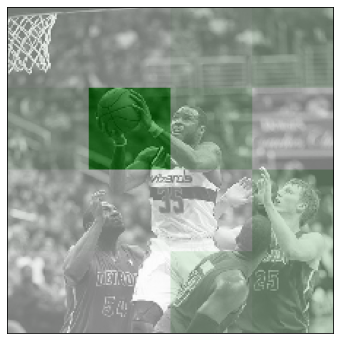

In [12]:
# show feature map

# create sorted list with mean of patch probability

patch_amount = len(patches)

# create sorted list with mean patch probability
sorted_after_probability, sorted_after_patch = fm.mean_tuple_list(patch_amount, mean_list)

feature_map = fm.create_feature_map(patches, sorted_after_patch)

_ = viz.visualize_image_attr(feature_map, image_for_classification, method="blended_heat_map",sign="all",show_colorbar=False, 
                            title="")